<a href="https://colab.research.google.com/github/Dewwbe/Deep-learning-Lab-07-Part-2-Deep-Q-Learning-DQN-/blob/main/RL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ================================================================
# LAB 02 – Deep Q-Learning (DQN)
# ================================================================

# ===============================
# 1. Imports and setup
# ===============================
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

Running on: cpu


In [3]:
# ===============================
# 2. GridWorld Environment (from Lab 01)
# ===============================
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.start = (0, 0)
        self.goal = (size - 1, size - 1)
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self._get_state_index(self.state)

    def _get_state_index(self, state):
        return state[0] * self.size + state[1]

    def _get_coords(self, index):
        return (index // self.size, index % self.size)

    def step(self, action):
        x, y = self.state
        if action == 0:   # up
            x = max(x - 1, 0)
        elif action == 1: # down
            x = min(x + 1, self.size - 1)
        elif action == 2: # left
            y = max(y - 1, 0)
        elif action == 3: # right
            y = min(y + 1, self.size - 1)

        self.state = (x, y)
        reward = 1 if self.state == self.goal else -0.01
        done = self.state == self.goal
        return self._get_state_index(self.state), reward, done

    def get_state_space(self):
        return self.size * self.size

    def get_action_space(self):
        return 4  # up, down, left, right


In [4]:

# ===============================
# 3. DQN Neural Network
# ===============================
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)



In [5]:
# ===============================
# 4. Experience Replay Buffer
# ===============================
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(state).to(device),
            torch.LongTensor(action).to(device),
            torch.FloatTensor(reward).to(device),
            torch.FloatTensor(next_state).to(device),
            torch.FloatTensor(done).to(device),
        )

    def __len__(self):
        return len(self.buffer)



In [6]:
# ===============================
# 5. DQN Agent
# ===============================
class DQNAgent:
    def __init__(self, state_size, action_size, epsilon):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.gamma = 0.99
        self.lr = 1e-3
        self.batch_size = 64
        self.update_target_every = 50

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()
        self.memory = ReplayBuffer()

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.step_count = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.policy_net(state_t)
            return q_values.argmax().item()

    def remember(self, *args):
        self.memory.push(*args)

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return 0.0

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        q_values = self.policy_net(states)
        next_q_values = self.target_net(next_states)

        q_target = q_values.clone()
        for i in range(self.batch_size):
            q_target[i, actions[i]] = rewards[i] + self.gamma * torch.max(next_q_values[i]) * (1 - dones[i])

        loss = self.loss_fn(q_values, q_target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.step_count += 1
        if self.step_count % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()


In [7]:

# ===============================
# 6. Training the DQN
# ===============================
def train_dqn(epsilon, episodes=500):
    env = GridWorld(size=5)
    state_size = env.get_state_space()
    action_size = env.get_action_space()
    agent = DQNAgent(state_size, action_size, epsilon)

    rewards_history = []
    losses = []

    for episode in range(episodes):
        state_idx = env.reset()
        state = np.zeros(state_size)
        state[state_idx] = 1  # one-hot encoding

        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state_idx, reward, done = env.step(action)

            next_state = np.zeros(state_size)
            next_state[next_state_idx] = 1

            agent.remember(state, action, reward, next_state, done)
            loss = agent.train_step()
            losses.append(loss)

            state = next_state
            total_reward += reward

        rewards_history.append(total_reward)
        if episode % 50 == 0:
            print(f"Epsilon={epsilon} | Episode={episode} | Total Reward={total_reward:.2f}")

    return rewards_history, losses

In [8]:

# ===============================
# 7. Run experiments for different epsilons
# ===============================
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\n--- Training with epsilon={eps} ---")
    rewards, losses = train_dqn(eps)
    results[eps] = (rewards, losses)



--- Training with epsilon=0.1 ---
Epsilon=0.1 | Episode=0 | Total Reward=-0.90
Epsilon=0.1 | Episode=50 | Total Reward=0.93
Epsilon=0.1 | Episode=100 | Total Reward=0.93
Epsilon=0.1 | Episode=150 | Total Reward=0.93
Epsilon=0.1 | Episode=200 | Total Reward=0.93
Epsilon=0.1 | Episode=250 | Total Reward=0.93
Epsilon=0.1 | Episode=300 | Total Reward=0.93
Epsilon=0.1 | Episode=350 | Total Reward=0.91
Epsilon=0.1 | Episode=400 | Total Reward=0.93
Epsilon=0.1 | Episode=450 | Total Reward=0.91

--- Training with epsilon=0.5 ---
Epsilon=0.5 | Episode=0 | Total Reward=-1.64
Epsilon=0.5 | Episode=50 | Total Reward=0.89
Epsilon=0.5 | Episode=100 | Total Reward=0.89
Epsilon=0.5 | Episode=150 | Total Reward=0.91
Epsilon=0.5 | Episode=200 | Total Reward=0.85
Epsilon=0.5 | Episode=250 | Total Reward=0.80
Epsilon=0.5 | Episode=300 | Total Reward=0.86
Epsilon=0.5 | Episode=350 | Total Reward=0.92
Epsilon=0.5 | Episode=400 | Total Reward=0.93
Epsilon=0.5 | Episode=450 | Total Reward=0.81

--- Training 

In [9]:
# ===============================
# 7. Run experiments for different epsilons
# ===============================
epsilons = [0.1, 0.5, 0.9]
results = {}

for eps in epsilons:
    print(f"\n--- Training with epsilon={eps} ---")
    rewards, losses = train_dqn(eps)
    results[eps] = (rewards, losses)


--- Training with epsilon=0.1 ---
Epsilon=0.1 | Episode=0 | Total Reward=-0.54
Epsilon=0.1 | Episode=50 | Total Reward=0.93
Epsilon=0.1 | Episode=100 | Total Reward=0.93
Epsilon=0.1 | Episode=150 | Total Reward=0.91
Epsilon=0.1 | Episode=200 | Total Reward=0.93
Epsilon=0.1 | Episode=250 | Total Reward=0.93
Epsilon=0.1 | Episode=300 | Total Reward=0.93
Epsilon=0.1 | Episode=350 | Total Reward=0.93
Epsilon=0.1 | Episode=400 | Total Reward=0.93
Epsilon=0.1 | Episode=450 | Total Reward=0.91

--- Training with epsilon=0.5 ---
Epsilon=0.5 | Episode=0 | Total Reward=-1.66
Epsilon=0.5 | Episode=50 | Total Reward=0.91
Epsilon=0.5 | Episode=100 | Total Reward=0.88
Epsilon=0.5 | Episode=150 | Total Reward=0.88
Epsilon=0.5 | Episode=200 | Total Reward=0.77
Epsilon=0.5 | Episode=250 | Total Reward=0.91
Epsilon=0.5 | Episode=300 | Total Reward=0.89
Epsilon=0.5 | Episode=350 | Total Reward=0.91
Epsilon=0.5 | Episode=400 | Total Reward=0.87
Epsilon=0.5 | Episode=450 | Total Reward=0.93

--- Training 

In [9]:
# You might need to restart the runtime after running this cell
!pip install torch==2.2.0 torchvision==0.17.0 -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.4/755.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 806.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

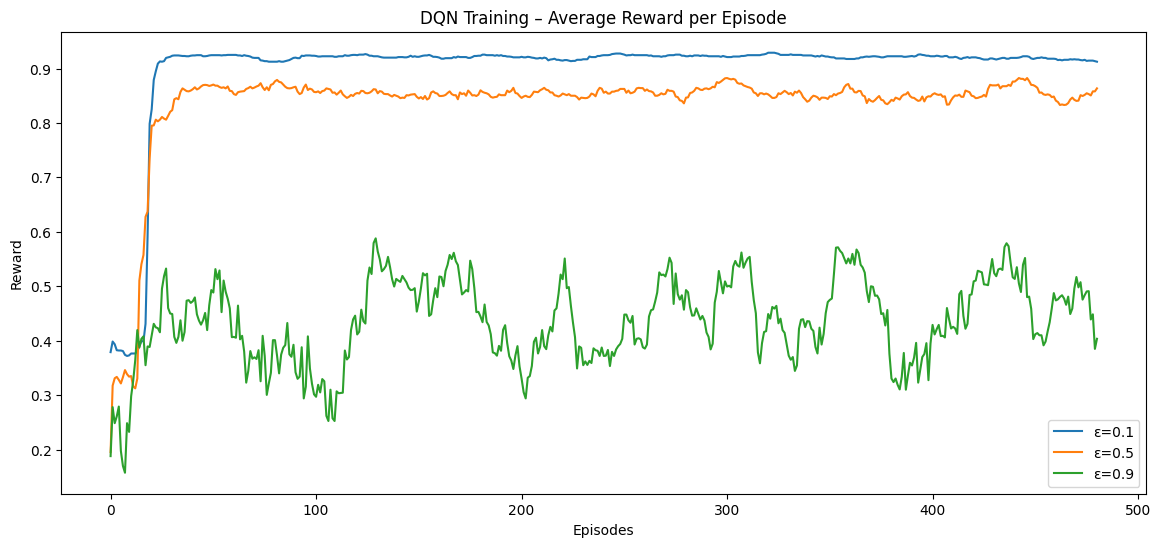

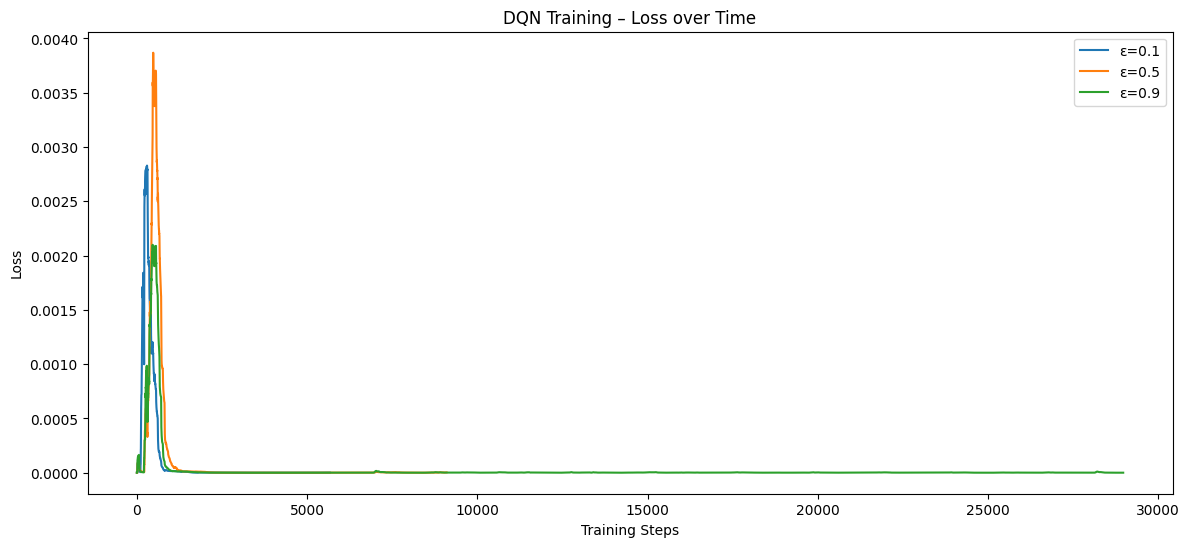

In [10]:
# ===============================
# 8. Plot Results
# ===============================
plt.figure(figsize=(14, 6))
for eps in epsilons:
    plt.plot(np.convolve(results[eps][0], np.ones(20)/20, mode='valid'), label=f"ε={eps}")
plt.title("DQN Training – Average Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
for eps in epsilons:
    plt.plot(np.convolve(results[eps][1], np.ones(50)/50, mode='valid'), label=f"ε={eps}")
plt.title("DQN Training – Loss over Time")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
# ===============================
# 9. Observations
# ===============================
print("""
Observations:
- Higher epsilon (e.g., 0.9) leads to more exploration but slower convergence.
- Lower epsilon (e.g., 0.1) focuses on exploitation, converging faster but risking suboptimal paths.
- DQN stabilizes learning using experience replay and target networks.
""")


Observations:
- Higher epsilon (e.g., 0.9) leads to more exploration but slower convergence.
- Lower epsilon (e.g., 0.1) focuses on exploitation, converging faster but risking suboptimal paths.
- DQN stabilizes learning using experience replay and target networks.

